In [35]:
%matplotlib inline

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
wave_lengths = pd.read_csv("data_training/wave_lengths.csv",index_col=0,header=None)[1]

# Dataset 

In [38]:
X_explore = pd.read_csv("data_training/20211118_spectrum_avg_norm_zscore.csv",index_col=0)
del X_explore["file"]
del X_explore["is_background"]
y_leave =  X_explore["is_leave"]
y_aphid =  X_explore["is_aphid"]
del X_explore["is_leave"]
del X_explore["is_aphid"]
X_explore
X = X_explore
y = y_aphid

In [46]:
X.T.mean(),X.T.std()

(0
 0_NA9R1F      -3.796566e-16
 1_NA9R1F       1.842648e-15
 2_NA9R1F       1.295219e-15
 3_NA9R1F      -3.068400e-14
 4_NA9R1F      -5.688654e-16
                    ...     
 46_VL4R3      -1.757027e-15
 47_VL4R3       8.046019e-15
 48_VL4R3       1.814892e-15
 49_VL4R3       7.063732e-16
 aphid_VL4R3   -1.555799e-15
 Length: 8109, dtype: float64,
 0
 0_NA9R1F       1.0
 1_NA9R1F       1.0
 2_NA9R1F       1.0
 3_NA9R1F       1.0
 4_NA9R1F       1.0
               ... 
 46_VL4R3       1.0
 47_VL4R3       1.0
 48_VL4R3       1.0
 49_VL4R3       1.0
 aphid_VL4R3    1.0
 Length: 8109, dtype: float64)

In [11]:
from collections import Counter
Counter(y)

Counter({0.0: 7951, 1.0: 158})

# Optimization of One-Class-SVM meta-parameters and Sensitivity

In [34]:
from sklearn.model_selection import ParameterSampler,ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import OneClassSVM
from sklearn import metrics
import scipy
from time import time
from tqdm.autonotebook import tqdm

In [14]:
X = X.values
y = y.values

In [19]:
def evaluate_full(gamma,nu,X_train,X_val,y_val):
    oc_svm = OneClassSVM(gamma=gamma,
                         nu=nu,
                         #tol=1e-3,
                         #shrinking=False
                        )
    t = time()
    oc_svm.fit(X_train)
    runtime = time() - t
    y_pred = oc_svm.predict(X_val)>0
    scores = oc_svm.decision_function(X_val)
    precision = metrics.precision_score(y_val,y_pred,zero_division=0)
    recall = metrics.recall_score(y_val,y_pred,zero_division=0)
    f1 = metrics.f1_score(y_val,y_pred,zero_division=0)
    auroc = metrics.roc_auc_score(y_val, scores)
    p, r, thresholds = metrics.precision_recall_curve(y_val, scores)
    aupr = metrics.auc(r,p)
    nb_sv = oc_svm.n_support_[0]/X_train.shape[0]
    return({"precision":precision,"recall":recall,'f1':f1,'auroc':auroc,'aupr':aupr,'nb SV':nb_sv, 'train time':runtime})
    
    
cv_split = 10
params_distrib = {'gamma': scipy.stats.expon(scale=1e-3),
                  'nu': scipy.stats.expon(scale=1e-1)}

skf = StratifiedKFold(n_splits=cv_split,shuffle=True)
results_random_search_cv = []
i = 0
for train, val in tqdm(list(skf.split(X, y))):
    X_train = X[train,:]
    X_val = X[val,:]
    y_train = y[train]
    y_val = y[val]
    X_train_pos = X_train[y_train>0]
    results_local = []
    for p in ParameterGrid({"gamma":[1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1],
                            "nu":[1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}):
        res = evaluate_full(p["gamma"],p["nu"],X_train_pos,X_val,y_val)
        res.update(p)
        res["cv"]=i
        results_local.append(res)
    results_random_search_cv.append(pd.DataFrame(results_local))
    i+=1

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
results_random_search_cv = pd.concat(results_random_search_cv)

In [21]:
results_random_search_cv

precision  recall   f1     auroc      aupr     nb SV  train time  \
0          0.0     0.0  0.0  0.998409  0.947023  0.006993    0.000522   
1          0.0     0.0  0.0  0.997906  0.925385  0.013986    0.000402   
2          0.0     0.0  0.0  0.997487  0.905853  0.104895    0.000650   
3          0.0     0.0  0.0  0.994305  0.745858  0.202797    0.000939   
4          0.0     0.0  0.0  0.993551  0.704563  0.300699    0.001195   
..         ...     ...  ...       ...       ...       ...         ...   
116        0.0     0.0  0.0  0.998574  0.926917  0.986014    0.002504   
117        0.0     0.0  0.0  0.998574  0.926917  0.986014    0.002560   
118        0.0     0.0  0.0  0.998574  0.926917  0.986014    0.002363   
119        0.0     0.0  0.0  0.998491  0.919047  0.986014    0.002236   
120        0.0     0.0  0.0  0.998323  0.905570  0.986014    0.002647   

            gamma     nu  cv  
0    1.000000e-10  0.001   0  
1    1.000000e-10  0.010   0  
2    1.000000e-10  0.100   0  
3    1.000000e-10  0.200   0  
4    1.000000e-10  0.300   0  
..            ...    ...  ..  
116  1.000000e+00  0.500   9  
117  1.000000e+00  0.600   9  
118  1.000000e+00  0.700   9  
119  1.000000e+00  0.800   9  
120  1.000000e+00  0.900   9  

[1210 rows x 10 columns]

In [22]:
results_random_search_cv.columns = ["precision",
                                    "recall","f1","auroc","aupr",'nb SV','train time',
                                    "gamma","nu",
                                    "cv"]

In [23]:
results_random_search_cv

precision  recall   f1     auroc      aupr     nb SV  train time  \
0          0.0     0.0  0.0  0.998409  0.947023  0.006993    0.000522   
1          0.0     0.0  0.0  0.997906  0.925385  0.013986    0.000402   
2          0.0     0.0  0.0  0.997487  0.905853  0.104895    0.000650   
3          0.0     0.0  0.0  0.994305  0.745858  0.202797    0.000939   
4          0.0     0.0  0.0  0.993551  0.704563  0.300699    0.001195   
..         ...     ...  ...       ...       ...       ...         ...   
116        0.0     0.0  0.0  0.998574  0.926917  0.986014    0.002504   
117        0.0     0.0  0.0  0.998574  0.926917  0.986014    0.002560   
118        0.0     0.0  0.0  0.998574  0.926917  0.986014    0.002363   
119        0.0     0.0  0.0  0.998491  0.919047  0.986014    0.002236   
120        0.0     0.0  0.0  0.998323  0.905570  0.986014    0.002647   

            gamma     nu  cv  
0    1.000000e-10  0.001   0  
1    1.000000e-10  0.010   0  
2    1.000000e-10  0.100   0  
3    1.000000e-10  0.200   0  
4    1.000000e-10  0.300   0  
..            ...    ...  ..  
116  1.000000e+00  0.500   9  
117  1.000000e+00  0.600   9  
118  1.000000e+00  0.700   9  
119  1.000000e+00  0.800   9  
120  1.000000e+00  0.900   9  

[1210 rows x 10 columns]

In [24]:
df = results_random_search_cv[(results_random_search_cv["gamma"] == 1e-2) & (results_random_search_cv["nu"] == 1e-2) ][["precision","recall","f1","auroc","aupr","train time","cv"]]
df["Algorithm"] = "OC-SVM"
df["Imbalance correction"] = "_"
df

precision    recall        f1     auroc      aupr  train time  cv  \
89   1.000000  0.866667  0.928571  0.999330  0.973680    0.000514   0   
89   1.000000  0.875000  0.933333  1.000000  1.000000    0.000420   1   
89   1.000000  0.937500  0.967742  0.999843  0.992851    0.000397   2   
89   0.866667  0.812500  0.838710  0.997642  0.925917    0.000392   3   
89   1.000000  0.875000  0.933333  0.999921  0.996209    0.000450   4   
89   1.000000  1.000000  1.000000  1.000000  1.000000    0.000451   5   
89   1.000000  0.937500  0.967742  1.000000  1.000000    0.000421   6   
89   0.941176  1.000000  0.969697  0.999057  0.923325    0.000450   7   
89   1.000000  1.000000  1.000000  1.000000  1.000000    0.000445   8   
89   0.928571  0.866667  0.896552  0.999665  0.980804    0.000614   9   

   Algorithm Imbalance correction  
89    OC-SVM                    _  
89    OC-SVM                    _  
89    OC-SVM                    _  
89    OC-SVM                    _  
89    OC-SVM                    _  
89    OC-SVM                    _  
89    OC-SVM                    _  
89    OC-SVM                    _  
89    OC-SVM                    _  
89    OC-SVM                    _

In [26]:
df[["precision","recall","f1","auroc","aupr","train time"]].mean()

precision     0.973641
recall        0.917083
f1            0.943568
auroc         0.999546
aupr          0.979279
train time    0.000455
dtype: float64

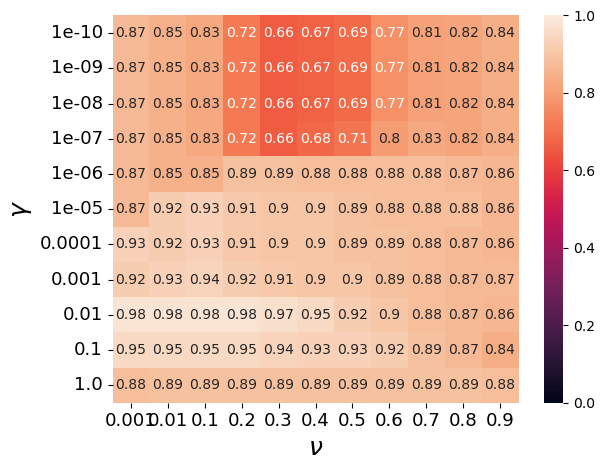

In [27]:
sns.heatmap(results_random_search_cv.pivot_table(index="gamma",
                                                 columns="nu", 
                                                 values="aupr").round(2),
            annot=True,vmin=0, vmax=1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("$\\nu$",fontsize=18)
plt.ylabel("$\gamma$",fontsize=18)
plt.tight_layout()
#plt.savefig("AUPR.pdf")

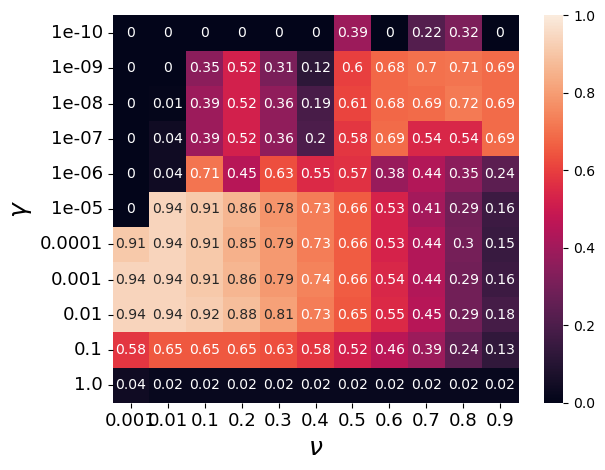

In [28]:
sns.heatmap(results_random_search_cv.pivot_table(index="gamma", columns="nu", values="f1").round(2),
            annot=True,vmin=0, vmax=1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("$\\nu$",fontsize=18)
plt.ylabel("$\gamma$",fontsize=18)
plt.tight_layout()
#plt.savefig("f1.pdf")

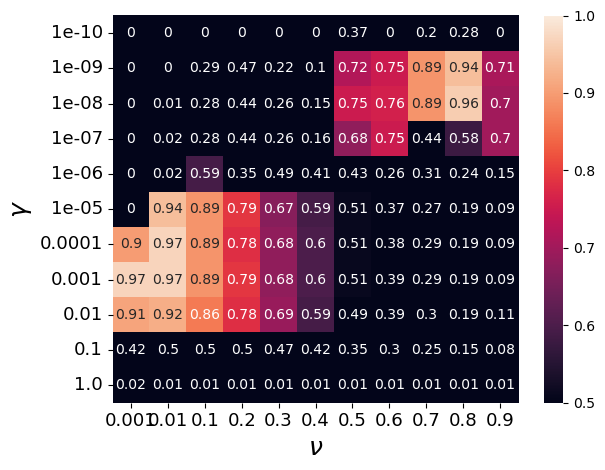

In [29]:
sns.heatmap(results_random_search_cv.pivot_table(index="gamma", columns="nu", values="recall").round(2),
            annot=True,vmin=0.5, vmax=1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("$\\nu$",fontsize=18)
plt.ylabel("$\gamma$",fontsize=18)
plt.tight_layout()
#plt.savefig("recall.pdf")

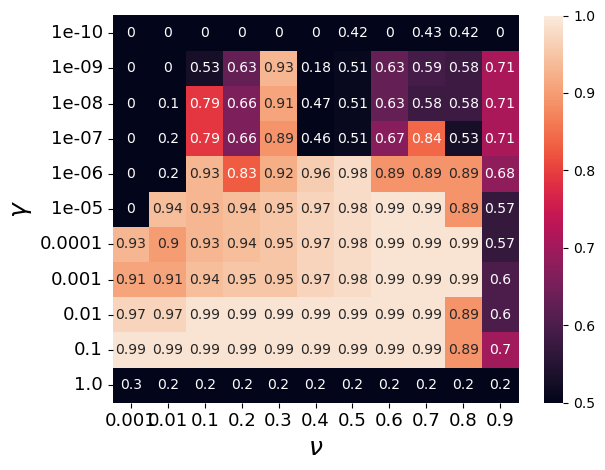

In [30]:
sns.heatmap(results_random_search_cv.pivot_table(index="gamma", columns="nu", values="precision").round(2),
            annot=True,vmin=0.5, vmax=1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("$\\nu$",fontsize=18)
plt.ylabel("$\gamma$",fontsize=18)
plt.tight_layout()
#plt.savefig("precision.pdf")

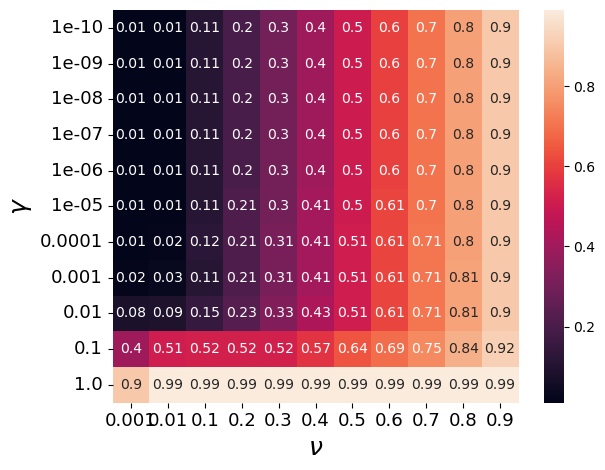

In [31]:
sns.heatmap(results_random_search_cv.pivot_table(index="gamma", columns="nu", values="nb SV").round(2),
            annot=True, fmt='g')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("$\\nu$",fontsize=18)
plt.ylabel("$\gamma$",fontsize=18)
plt.tight_layout()
#plt.savefig("nb_sv.pdf")

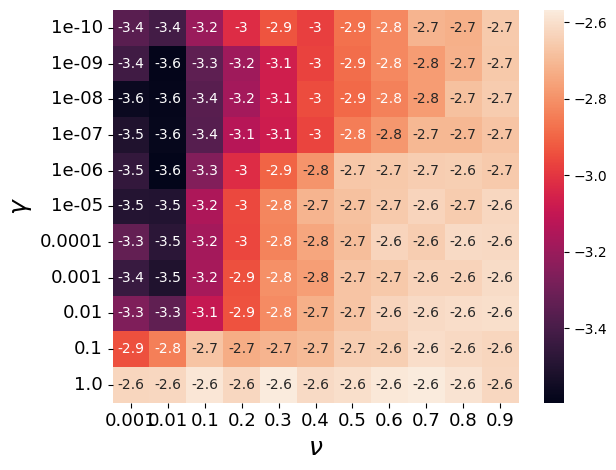

In [32]:
sns.heatmap(np.log10(results_random_search_cv.pivot_table(index="gamma", columns="nu", values="train time")),
            annot=True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("$\\nu$",fontsize=18)
plt.ylabel("$\gamma$",fontsize=18)
plt.tight_layout()
#plt.savefig("train_runtime.pdf")

# Train final model

In [33]:
svm = OneClassSVM(gamma=0.01,
                  nu=0.01)
svm.fit(X[y>0])

OneClassSVM(gamma=0.01, nu=0.01)

# Save model

In [47]:
from joblib import dump, load
dump(svm,'models/OCSVM_model.joblib')

['models/OCSVM_model.joblib']